In [1]:
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
%matplotlib inline
from matplotlib.pyplot import imshow

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms, utils

# Deep Neural Network Model (AlexNet)

In [2]:
class KitModel(nn.Module):

    def __init__(self):
        super(KitModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 96, (11, 11), stride=4, padding=0)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, groups=2, padding=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, groups=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, groups=2, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, groups=2, padding=1)
        self.fc6_1 = nn.Linear(in_features = 9216, out_features = 4096)
        self.fc7_1 = nn.Linear(in_features = 4096, out_features = 4096)
        self.ip_1 = nn.Linear(in_features = 4096, out_features = 1)
        
        self.relu = nn.ReLU()
        self.drop = nn.Dropout()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        conv1           = self.conv1(x)
        relu1           = self.relu(conv1)
        pool1           = self.maxpool(relu1)
        norm1           = self.LRN(size = 5, alpha=0.0001, beta=0.75)(pool1)
        
        conv2           = self.conv2(norm1)
        relu2           = self.relu(conv2)
        pool2           = self.maxpool(relu2)
        norm2           = self.LRN(size = 5, alpha=0.0001, beta=0.75)(pool2)
        
        conv3           = self.conv3(norm2)
        relu3           = self.relu(conv3)
        conv4           = self.conv4(relu3)
        relu4           = self.relu(conv4)
        conv5           = self.conv5(relu4)
        relu5           = self.relu(conv5)
        pool5           = self.maxpool(relu5)
        
        fc6_0           = pool5.view(pool5.size(0), -1)
        
        fc6_1           = self.fc6_1(fc6_0)
        relu6           = self.relu(fc6_1)
        drop6           = self.drop(relu6)
        fc7_1           = self.fc7_1(drop6)
        relu7           = self.relu(fc7_1)
        ip_0            = self.drop(relu7)
        ip_1            = self.ip_1(ip_0)
        
        return ip_1
    
    class LRN(nn.Module):
        def __init__(self, size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=True):
            super(KitModel.LRN, self).__init__()
            self.ACROSS_CHANNELS = ACROSS_CHANNELS
            if self.ACROSS_CHANNELS:
                self.average=nn.AvgPool3d(kernel_size=(size, 1, 1),
                        stride=1,
                        padding=(int((size-1.0)/2), 0, 0))
            else:
                self.average=nn.AvgPool2d(kernel_size=size,
                        stride=1,
                        padding=int((size-1.0)/2))
            self.alpha = alpha
            self.beta = beta

        def forward(self, x):
            if self.ACROSS_CHANNELS:
                div = x.pow(2).unsqueeze(1)
                div = self.average(div).squeeze(1)
                div = div.mul(self.alpha).add(1.0).pow(self.beta)
            else:
                div = x.pow(2)
                div = self.average(div)
                div = div.mul(self.alpha).add(1.0).pow(self.beta)
            x = x.div(div)
            return x

In [4]:
model = KitModel()

model.load_state_dict(torch.load('generated_files/pytorch_state.npy'))
model.train(False)
model.eval()

KitModel(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (fc6_1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc7_1): Linear(in_features=4096, out_features=4096, bias=True)
  (ip_1): Linear(in_features=4096, out_features=1, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.5, inplace=False)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [3]:
class PandasDataset(Dataset):
    def __init__(self, list_images, list_targets, transform=None):
        self.list_images = list_images
        self.list_targets = list_targets
        # add transforms as well
        self.transform = transform

    def __getitem__(self, idx):
        
        image = Image.open(self.list_images[idx]).convert('RGB')
        image = image.resize((227,227), Image.BILINEAR) 
        image = np.array(image, dtype='f4')
        # Convert RGB to BGR 
        image = image[:, :, ::-1]
        
        image = image.astype('float32')
        
        # add transforms
        if self.transform:
            image = self.transform(image)
            
        return image, self.list_targets[idx]

    def __len__(self):
        return len(self.list_images)

In [34]:
batch_size = 1

file_list = [
    'data/marghera.png',
    
    'data/povo.png',
]
# I'm interested only in testing the predictions, so label=0
labels = [
    0,0
]

## Example of image

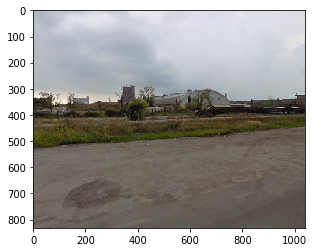

In [35]:
image = Image.open(file_list[0]).convert('RGB')
imshow(np.array(image))

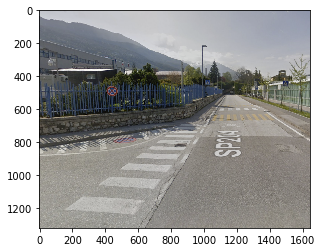

In [36]:
image = Image.open(file_list[1]).convert('RGB')
imshow(np.array(image))

In [37]:
means = np.load('generated_files/places205CNN_mean_filtered.npy')

transformations = transforms.Compose([lambda x: x - means, # Subtracts image means
                                      transforms.ToTensor(), 
                                      lambda x: x*255] # Restore the input range to [0, 255]
                                    )

dataset = PandasDataset(file_list, labels, transformations)


load = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)

preds = np.zeros((len(file_list), 1))

for i, data in enumerate(load):
    inputs, labels = data
    
    n = len(inputs)
    ifrom = i*batch_size
    ito = i*batch_size+n
    
    inputs, labels = Variable(inputs), Variable(labels)
    
    outputs = model(inputs.float())
    preds[ifrom:ito] = outputs.data.numpy()
    
print("Predicted:", preds)

Predicted: [[4.80148745]
 [5.17976761]]
